In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel.builder.aln import (
    ALN_EXC_DEFAULT_PARAMS,
    ALN_INH_DEFAULT_PARAMS,
    ALNNode,
)
from neurolib.models.multimodel.builder.thalamus import (
    TCR_DEFAULT_PARAMS,
    TRN_DEFAULT_PARAMS,
    ThalamicNode,
)
from neurolib.utils.signal import RatesSignal
from neurolib.utils.stimulus import OrnsteinUhlenbeckProcess, SquareInput, ZeroInput
from scipy.signal import find_peaks
from tqdm import tqdm

from spindle_detection import down_state_to_spindle_pow_max_peak
from utils import dummy_detect_down_states, get_amplitude, get_phase

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light.mplstyle")

SAVE_FIG = True

In [2]:
class StimulatedThalamus:

    # all times in ms
    DURATION = 30000.0
    T_SPIN_UP = 5000.0
    DT = 0.01

    def __init__(self, glk=0.033, gh=0.062, tcr_noise=0.0):
        """
        Initialise thalamus model here.
        """
        tcr_params = {**TCR_DEFAULT_PARAMS, "g_LK": glk, "g_h": gh}
        trn_params = {**TRN_DEFAULT_PARAMS, "g_LK": glk}
        # init model
        self.model = ThalamicNode(tcr_params=tcr_params, trn_params=trn_params)
        self.model.index = 0
        self.model.idx_state_var = 0
        self.model.init_node()
        self.tcr_noise = tcr_noise

    def get_square_pulse_stim(self, stim_inp=0.0, period=10000):
        """
        Prepare square pulse stimulation.
        """
        stim = SquareInput(
            start=None,
            amplitude=stim_inp / 1000.0,
            frequency=1000.0 / period,
            dc_bias=True,
        )

        tcr_input = OrnsteinUhlenbeckProcess(mu=0.0, sigma=self.tcr_noise, tau=5.0)
        tcr_input += stim

        trn_input = ZeroInput()
        trn_input += stim
        return (
            tcr_input.as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT),
            trn_input.as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT),
        )

    def _prepare_aln_ts(self, e, i, noise):
        params_update = {"a": 0.0, "b": 15.0, "tauA": 1000.0}
        aln = ALNNode(
            exc_params={**ALN_EXC_DEFAULT_PARAMS, **params_update},
            inh_params={**ALN_INH_DEFAULT_PARAMS, **params_update},
        )
        aln.index = 0
        aln.idx_state_var = 0
        aln.init_node()

        noise_exc = OrnsteinUhlenbeckProcess(
            mu=e,
            sigma=noise,
            tau=5,
            seed=42,
        ).as_array(self.DURATION + self.T_SPIN_UP, self.DT)
        noise_inh = OrnsteinUhlenbeckProcess(
            mu=i,
            sigma=noise,
            tau=5,
            seed=512,
        ).as_array(self.DURATION + self.T_SPIN_UP, self.DT)
        results = aln.run(
            duration=self.DURATION + self.T_SPIN_UP,
            dt=self.DT,
            noise_input=np.vstack([noise_exc, noise_inh]),
            backend="numba",
        )
        return results

    def get_aln_so(self, e, noise):
        aln_res = self._prepare_aln_ts(e=e, i=2.0, noise=noise)
        aln_ts = aln_res["r_mean_EXC"].values.squeeze()
        so_stim = aln_ts[np.newaxis, :]

        tcr_input = OrnsteinUhlenbeckProcess(
            mu=0.0, sigma=self.tcr_noise, tau=5.0
        ).as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT)
        tcr_input += so_stim

        trn_input = ZeroInput().as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT)
        trn_input += so_stim

        return tcr_input, trn_input

    def run(self, tcr_input, trn_input):
        """
        Run the model.
        """
        results = self.model.run(
            duration=self.DURATION + self.T_SPIN_UP,
            dt=self.DT,
            noise_input=np.vstack([tcr_input, trn_input]),
            backend="numba",
        )
        tcr = results["r_mean_EXC"].isel({"node": 0}) * 1000.0
        trn = results["r_mean_INH"].isel({"node": 0}) * 1000.0

        results_df = pd.DataFrame(
            {
                "TCR": tcr.values,
                "TRN": trn.values,
                "ALN": tcr_input.squeeze() * 1000.0,
            },
            index=tcr.time,
        )
        results_df.index.name = "time"
        return results_df.loc[self.T_SPIN_UP / 1000.0 :]


def plot_single(df, ax, ax2legend=False):
    ax.plot(df.index, df["TRN"], color="C1", alpha=0.7, linewidth=0.8)
    ax.plot(df.index, df["TCR"], color="C0", alpha=0.7, linewidth=0.8)
    ax.set_yticklabels([0, 200, 400])
    sns.despine(trim=True, ax=ax)
    ax2 = ax.twinx()
    ax2.plot(df.index, df["ALN"], color="k", linewidth=1.5, alpha=0.9)
    if ax2legend:
        ax2.set_ylabel("$r_{stim}$")
        ax2.yaxis.set_label_coords(1.05, 0.13)
    ax2.set_ylim([-10, 300.0])
    ax2.set_yticks([0.0, 60.0])
    sns.despine(trim=False, ax=ax2)

 67%|██████▋   | 4/6 [01:02<00:35, 17.95s/it]/Users/nikola/.virtualenvs/paper_thlm_aln/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator


Setting up band-pass filter from 12 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 110001 samples (1.100 sec)



 83%|████████▎ | 5/6 [01:24<00:19, 19.50s/it]/Users/nikola/.virtualenvs/paper_thlm_aln/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator


Setting up band-pass filter from 12 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 110001 samples (1.100 sec)



100%|██████████| 6/6 [01:52<00:00, 18.82s/it]


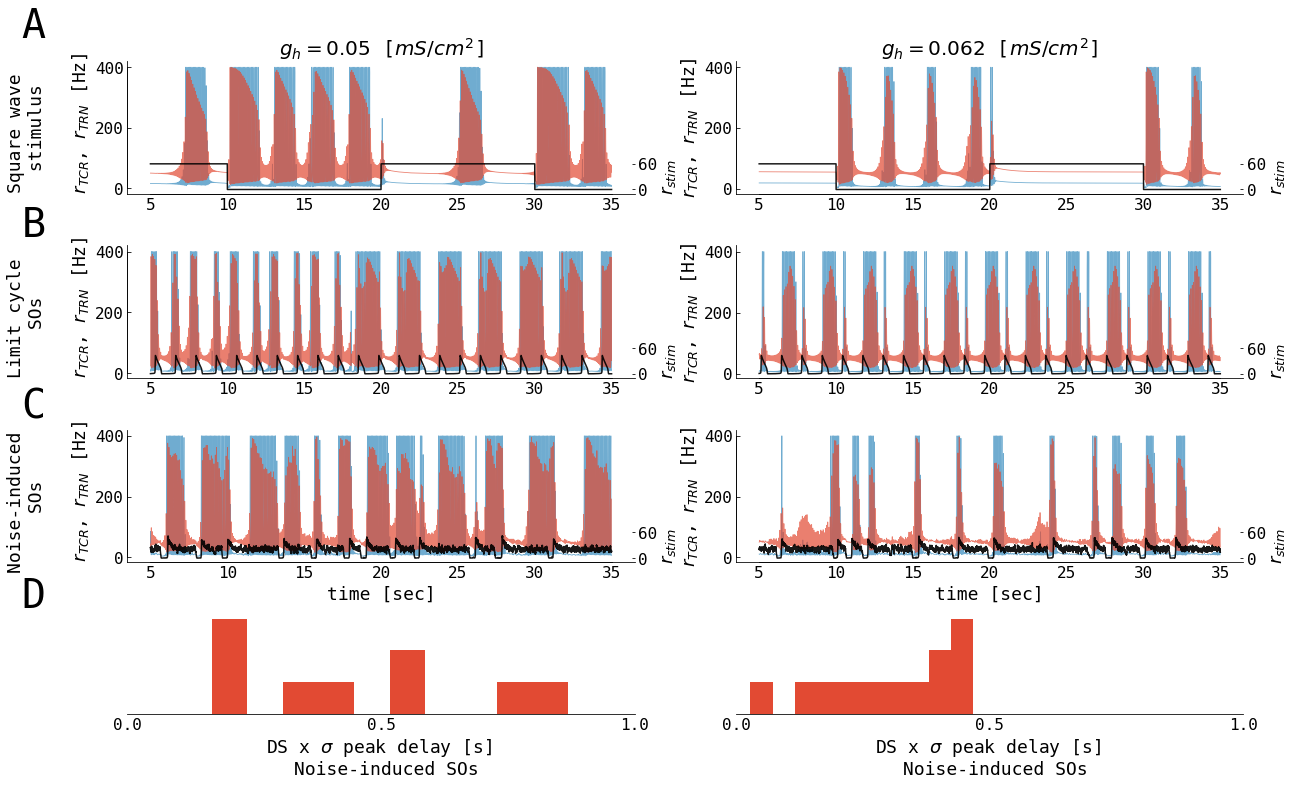

In [3]:
PERIOD = 20000
noises = [0.0]  # , 0.005]
ghs = [0.05, 0.062]

pbar = tqdm(total=3 * len(noises) * len(ghs))

for noise in noises:
    fig, axs = plt.subplots(
        ncols=len(ghs),
        nrows=7,
        sharex=False,
        sharey=False,
        figsize=(20, 12),
        gridspec_kw={"height_ratios": [1, 0.15, 1, 0.15, 1, 0.15, 0.75]},
    )

    for ax in axs[1, :]:
        ax.axis("off")
    for ax in axs[3, :]:
        ax.axis("off")
    for ax in axs[5, :]:
        ax.axis("off")

    for i, gh in enumerate(ghs):
        thalamus = StimulatedThalamus(gh=gh, tcr_noise=noise)
        tcr_inp, trn_inp = thalamus.get_square_pulse_stim(stim_inp=30.0, period=PERIOD)
        df = thalamus.run(tcr_inp, trn_inp)
        ax = axs[0, i]
        plot_single(df, ax, ax2legend=True)
        ax.set_title(f"$g_{{h}}={gh}$ [$mS/cm^2$]")
        if i == 0:
            ax.set_ylabel("Square wave \n stimulus \n\n $r_{TCR}$, $r_{TRN}$ [Hz]")
        else:
            ax.set_ylabel("$r_{TCR}$, $r_{TRN}$ [Hz]")
        pbar.update(1)

    aln_settings = [(2.8, 0.0, "Limit cycle"), (3.5, 0.05, "Noise-induced")]
    for i, (aln_e, aln_noise, subtitle) in enumerate(aln_settings):
        for k, gh in enumerate(ghs):
            thalamus = StimulatedThalamus(gh=gh, tcr_noise=noise)
            tcr_inp, trn_inp = thalamus.get_aln_so(e=aln_e, noise=aln_noise)
            df = thalamus.run(tcr_inp, trn_inp)
            ax = axs[2 * i + 2, k]
            plot_single(df, ax, ax2legend=True)
            if k == 0:
                ax.set_ylabel(f"{subtitle} \n SOs \n\n $r_{{TCR}}$, $r_{{TRN}}$ [Hz]")
            else:
                ax.set_ylabel("$r_{{TCR}}$, $r_{{TRN}}$ [Hz]")
            if aln_noise != 0.0:
                pks_delay = down_state_to_spindle_pow_max_peak(
                    df, return_ds_indices=False, max_delay_ds_spindle=1.0
                )
                ax = axs[-1, k]
                ax.hist(pks_delay, bins=10)
                sns.despine(ax=ax, bottom=False, left=True)
                ax.set_xticks(np.arange(0, 1.1, 0.5))
                ax.set_yticks([])
                ax.set_xlim([0.0, 1.0])
                ax.set_xlabel(f"DS x $\sigma$ peak delay [s] \n {subtitle} SOs")
            pbar.update(1)

    # for ax in axs[-1, :]:
    #     ax.set_xticks([0, 1])
    #     ax.set_xticklabels([subtit for _, _, subtit in aln_settings])

    for ax in axs[-3, :]:
        ax.set_xlabel("time [sec]")

    plt.text(
        0.06,
        0.92,
        "A",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    plt.text(
        0.06,
        0.69,
        "B",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    plt.text(
        0.06,
        0.48,
        "C",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    plt.text(
        0.06,
        0.26,
        "D",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    plt.tight_layout()
    # to PDF due transparency
    if SAVE_FIG:
        plt.savefig(
            f"../figs/thalamus_square_stim_ts_sigma{noise}.pdf",
            dpi=DPI,
            transparent=True,
            bbox_inches="tight",
        )

pbar.close()